### Test Fitting Mock CARMA light curve using Celerite Kernels

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 07-16-20
<br>**Short description:** Fit CARMA light curves using `celerite` GP kernels 

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
%matplotlib inline

In [2]:
# import kali
import kali.carma

### 1. Simulate DRW LC

In [3]:
# simulate DRW using Kali
np.random.seed(42)
drw_task = kali.carma.CARMATask(1,0)
theta = np.array([1/100, 0.0495])
drw_task.set(1.0, theta)
drw_lc = drw_task.simulate(duration=365.25*100)

The percentage error is -51.71%


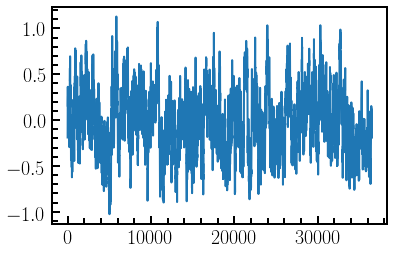

In [4]:
# plot original
plt.plot(drw_lc.t[::5], drw_lc.x[::5])

# print error
model_amp = np.sqrt(0.1**2*100/2)
print(f'The percentage error is {100*(np.std(drw_lc.x)-model_amp)/model_amp:.2f}%')

Std of shortened LC: 0.29350575142112456


Text(0, 0.5, 'Flux (arb. unit)')

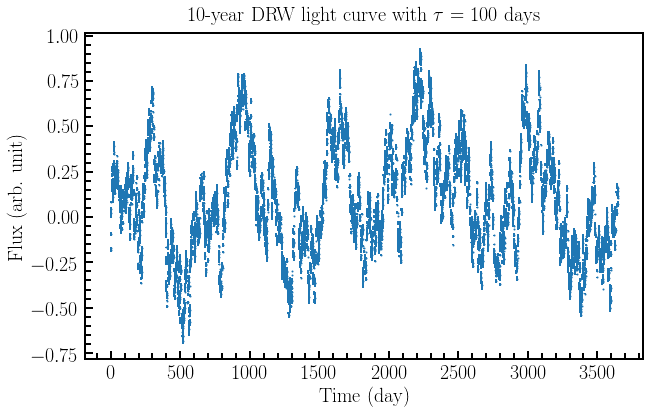

In [5]:
# add 0.02 mag error and shorten to 10 years
t = drw_lc.t[:3650]
y_err = np.random.normal(0, 0.02, 3650)
y = drw_lc.x[:3650] + y_err
print(f'Std of shortened LC: {np.std(drw_lc.x[:3650])}')
fig = plt.figure(figsize=(10,6))
plt.errorbar(t, y, y_err, fmt='.', markersize=2)
plt.title('10-year DRW light curve with $\\tau$ = 100 days')
plt.xlabel('Time (day)')
plt.ylabel('Flux (arb. unit)')

### 2. Fit using Celerite Kernel

In [6]:
# import CARMA celerite term
from agntk.carma.CARMATerm import *
from scipy.optimize import minimize
from celerite import GP

In [7]:
# define log posterior function
def neg_log_prob(params, y, yerr, gp):
    gp.set_parameter_vector(params)
    amp = gp.kernel.get_rms_amp()
    model_std = np.sqrt(np.var(y) - np.var(yerr))
    
    if amp > 2*model_std:
        return np.inf
    
    return -gp.log_likelihood(y)

In [19]:
# initialize parameter in the possible range
init_tau = np.random.uniform(0, 365, 1)[0]
init_amp = np.random.uniform(0, 0.35, 1)[0]

kernel = DRW_term(np.log(init_amp), np.log(init_tau))
gp = GP(kernel, mean=np.mean(y))
gp.compute(t, y_err)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_prob, initial_params, method="L-BFGS-B", bounds=bounds, \
             args=(y, y_err, gp))

sol = np.exp(r.x)
model_std = np.sqrt(drw_task.Sigma()[0][0])
print(f'The MAP solution is: {sol}')
print(f'The percentage error is: {100*(sol[0]-model_std)/model_std, 100*(sol[1]-100)/100}')

The MAP solution is: [ 0.29204257 66.66626737]
The percentage error is: (-16.563522851684066, -33.33373262812037)


<span style='color:red'>The fitting offset could result from the shortened LC having a different variance. In other words, the algorithm is returning a correct answer based-on the provided cut of the LC. We can compuare the model variance using the cutted LC and reverse enginer the true parameters. </span>

In [20]:
sample_model_std = np.sqrt(np.var(y)-np.var(y_err))
sample_tau = 100*(sample_model_std/model_std)**2
print(f'The sample model std estimated using the shortened LC: {sample_model_std}')
print(f'The derived sample tau from the LC: {sample_tau}')

The sample model std estimated using the shortened LC: 0.29344075245144896
The derived sample tau from the LC: 70.28464458669323


<span style='color:red'>We can see that `celerite` is doing what it can to provide the best estimate given the data. __NOTE:__ Although, most of the fitting faliures spotted above are due to the sub-optimal simulation of the light curves and nothing seems wrong with the GP, but it is still likely to get numerically unstable result from the optimizer. In the end, the optimizer stops the iteration and returns incorrect estimation of the model parameters. </span>